In [43]:
#导入需要的包

import paddle
import paddle.fluid as fluid
import numpy as np
from PIL import Image
import sys
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import os
paddle.enable_static()

In [44]:
!tar -zxvf data/cifar-10-python.tar.gz

tar (child): data/cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [45]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

print(unpickle("cifar-10-batches-py/data_batch_1").keys())
print(unpickle("cifar-10-batches-py/test_batch").keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [46]:
def test_mapper(sample):
    img, label = sample
    #将img数组进行进行归一化处理，得到0到1之间的数值
    img= img.flatten().astype('float32')/255.0
    return img, label



In [47]:
def train_mapper(sample):
    img, label = sample
    #将img数组进行进行归一化处理，得到0到1之间的数值
    img= img.flatten().astype('float32')/255.0
    return img, label

In [48]:
def train_r( buffered_size=1024):
    def reader():
        xs=[]
        ys=[]
        for i in range(1,6):
            train_dict=unpickle("cifar-10-batches-py/data_batch_%d" % (i,))
            xs.append(train_dict[b'data'])
            ys.append(train_dict[b'labels'])
        
        Xtr = np.concatenate(xs)
        Ytr = np.concatenate(ys)
    
        for (x,y) in zip(Xtr,Ytr):  
            yield x, int(y) 
    return paddle.reader.xmap_readers(train_mapper, reader,cpu_count(), buffered_size)

In [49]:
# 对自定义数据集创建训练集train的reader

def test_r( buffered_size=1024):
    def reader():
        test_dict=unpickle("cifar-10-batches-py/test_batch")
        X=test_dict[b'data']
        Y=test_dict[b'labels']
        for (x,y) in zip(X,Y):  
            yield x, int(y) 
    return paddle.reader.xmap_readers(test_mapper, reader,cpu_count(), buffered_size)

In [50]:
BATCH_SIZE = 128
#用于训练的数据提供器
train_reader = train_r()
train_reader = paddle.batch(
    paddle.reader.shuffle(
        reader=train_reader,buf_size=128*100),
    batch_size=BATCH_SIZE)
#用于测试的数据提供器
test_reader = test_r()
test_reader = paddle.batch(
    paddle.reader.shuffle(
        reader=test_reader,buf_size=300),
    batch_size=BATCH_SIZE)

In [51]:
def convolutional_neural_network(img):
    # 第一个卷积-池化层
    conv1=fluid.layers.conv2d(input=img,       #输入图像
                              num_filters=20,  #卷积核大小
                              filter_size=5,   #卷积核数量，它与输出的通道相同
                              act="relu")      #激活函数
    pool1 = fluid.layers.pool2d(
              input=conv1,                     #输入
              pool_size=2,                     #池化核大小
              pool_type='max',                 #池化类型
              pool_stride=2)                   #池化步长           
    conv_pool_1 = fluid.layers.batch_norm(pool1)

    # 第二个卷积-池化层
    conv2=fluid.layers.conv2d(input=conv_pool_1,
                              num_filters=50,
                              filter_size=5, 
                              act="relu")
    pool2 = fluid.layers.pool2d(
              input=conv2,
              pool_size=2,
              pool_type='max',
              pool_stride=2,
              global_pooling=False)
    conv_pool_2 = fluid.layers.batch_norm(pool2)
    # 第三个卷积-池化层
    conv3=fluid.layers.conv2d(input=conv_pool_2, num_filters=50, filter_size=5, act="relu")
    pool3 = fluid.layers.pool2d(
              input=conv3,
              pool_size=2,
              pool_type='max',
              pool_stride=2,
              global_pooling=False)   
    # 以softmax为激活函数的全连接输出层，10类数据输出10个数字
    prediction = fluid.layers.fc(input=pool3,
                                     size=10, 
                                     act='softmax')
    return prediction

In [52]:
#定义输入数据
data_shape = [3, 32, 32]
images = fluid.layers.data(name='images', shape=data_shape, dtype='float32')
label = fluid.layers.data(name='label', shape=[1], dtype='int64')

In [53]:
# 获取分类器，用cnn进行分类
predict =  convolutional_neural_network(images)

In [54]:
# 获取损失函数和准确率
cost = fluid.layers.cross_entropy(input=predict, label=label) # 交叉熵
avg_cost = fluid.layers.mean(cost)                            # 计算cost中所有元素的平均值
acc = fluid.layers.accuracy(input=predict, label=label)       #使用输入和标签计算准确率

In [55]:
# 获取测试程序
test_program = fluid.default_main_program().clone(for_test=True)
# 定义优化方法
optimizer =fluid.optimizer.Adam(learning_rate=0.00001)
optimizer.minimize(avg_cost)
print("完成")

完成


In [56]:
# 定义使用CPU还是GPU，使用CPU时use_cuda = False,使用GPU时use_cuda = True
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

W1120 19:41:39.852360   104 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W1120 19:41:39.857256   104 device_context.cc:372] device: 0, cuDNN Version: 7.6.


[]

In [57]:
feeder = fluid.DataFeeder( feed_list=[images, label],place=place)

In [58]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

Pass:0, Batch:0, Cost:2.75744, Accuracy:0.10156
Pass:0, Batch:20, Cost:2.92936, Accuracy:0.08594
Pass:0, Batch:40, Cost:2.88136, Accuracy:0.10938
Pass:0, Batch:60, Cost:2.88570, Accuracy:0.08594
Pass:0, Batch:80, Cost:2.56853, Accuracy:0.14062
Pass:0, Batch:100, Cost:2.59951, Accuracy:0.10156
Pass:0, Batch:120, Cost:2.78679, Accuracy:0.12500
Pass:0, Batch:140, Cost:2.51636, Accuracy:0.16406
Pass:0, Batch:160, Cost:2.68635, Accuracy:0.14062
Pass:0, Batch:180, Cost:2.43313, Accuracy:0.18750
Pass:0, Batch:200, Cost:2.53650, Accuracy:0.11719
Pass:0, Batch:220, Cost:2.43066, Accuracy:0.18750
Pass:0, Batch:240, Cost:2.58451, Accuracy:0.10156
Pass:0, Batch:260, Cost:2.47162, Accuracy:0.10156
Pass:0, Batch:280, Cost:2.45754, Accuracy:0.16406
Pass:0, Batch:300, Cost:2.36179, Accuracy:0.17188
Pass:0, Batch:320, Cost:2.31281, Accuracy:0.17969
Pass:0, Batch:340, Cost:2.43268, Accuracy:0.20312
Pass:0, Batch:360, Cost:2.42059, Accuracy:0.14062
Pass:0, Batch:380, Cost:2.29390, Accuracy:0.21094
Test:0

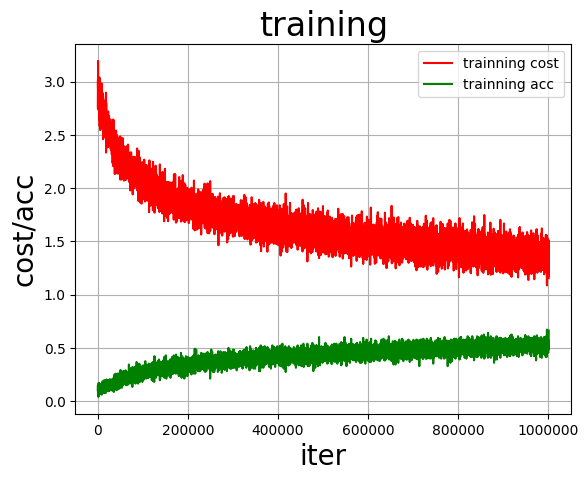

In [59]:
EPOCH_NUM = 20
model_save_dir = "/home/aistudio/work/catdog.inference.model"

for pass_id in range(EPOCH_NUM):
    # 开始训练
    for batch_id, data in enumerate(train_reader()):                        #遍历train_reader的迭代器，并为数据加上索引batch_id
        train_cost,train_acc = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),                        #喂入一个batch的数据
                             fetch_list=[avg_cost, acc])                    #fetch均方误差和准确率

        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
        
        #每100次batch打印一次训练、进行一次测试
        if batch_id % 20 == 0:                                             
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' % 
            (pass_id, batch_id, train_cost[0], train_acc[0]))
            

    # 开始测试
    test_costs = []                                                         #测试的损失值
    test_accs = []                                                          #测试的准确率
    for batch_id, data in enumerate(test_reader()):
        test_cost, test_acc = exe.run(program=test_program,                 #执行训练程序
                                      feed=feeder.feed(data),               #喂入数据
                                      fetch_list=[avg_cost, acc])           #fetch 误差、准确率
        test_costs.append(test_cost[0])                                     #记录每个batch的误差
        test_accs.append(test_acc[0])                                       #记录每个batch的准确率
    
    # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                         #计算误差平均值（误差和/误差的个数）
    test_acc = (sum(test_accs) / len(test_accs))                            #计算准确率平均值（ 准确率的和/准确率的个数）
    print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, test_cost, test_acc))
    
#保存模型
# 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
fluid.io.save_inference_model(model_save_dir,
                              ['images'],
                              [predict],
                              exe)
print('训练模型保存完成！')
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")


In [60]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope() 

In [61]:
def load_image(file):
        #打开图片
        im = Image.open(file)
        #将图片调整为跟训练数据一样的大小  32*32，                   设定ANTIALIAS，即抗锯齿.resize是缩放
        im = im.resize((32, 32), Image.ANTIALIAS)
        #建立图片矩阵 类型为float32
        im = np.array(im).astype(np.float32)
        #矩阵转置 
        im = im.transpose((2, 0, 1))                               
        #将像素值从【0-255】转换为【0-1】
        im = im / 255.0
        #print(im)       
        im = np.expand_dims(im, axis=0)
        # 保持和之前输入image维度一致
        print('im_shape的维度：',im.shape)
        return im

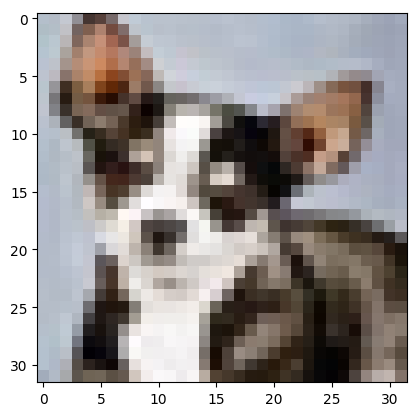

im_shape的维度： (1, 3, 32, 32)
im_shape的维度： (1, 3, 32, 32)
First image infer result: dog
Second image infer result: cat


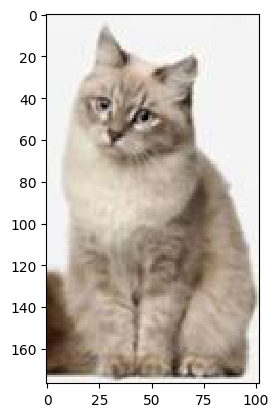

In [62]:
with fluid.scope_guard(inference_scope):
    # 从指定目录中加载推理model(inference model)
    [inference_program,  # 预测用的 program
     feed_target_names,  # 需要在推理 Program 中提供数据的变量的名称
     fetch_targets] = fluid.io.load_inference_model(model_save_dir,  # fetch_targets：是一个 Variable 列表，用于获取推断结果
                                                    infer_exe)       # infer_exe: 运行 inference model 的 executor

    # 加载两张图片
    infer_path = 'work/dog.png'
    infer1_path = 'work/cat.jpg'
    
    img = Image.open(infer_path)  # 打开第一张图片
    
    # 展示第一张图片
    plt.imshow(img)
    plt.show()

    # 加载两张图片的 numpy 数组形式
    img = load_image(infer_path)   # 加载第一张图片
    img1 = load_image(infer1_path)  # 加载第二张图片

    # 运行推理程序
    results1 = infer_exe.run(inference_program,                  # 运行预测程序
                             feed={feed_target_names[0]: img},   # 喂入要预测的第一张 img
                             fetch_list=fetch_targets)           # 得到第一张图片的推断结果

    results2 = infer_exe.run(inference_program,                  # 运行预测程序
                             feed={feed_target_names[0]: img1},  # 喂入要预测的第二张 img1
                             fetch_list=fetch_targets)           # 得到第二张图片的推断结果

    # 打印推理结果
    label_list = [
        "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
        "ship", "truck"
    ]
    
    # 输出第一张图片的推理结果
    print("First image infer result: %s" % label_list[np.argmax(results1[0])])

    img1 = Image.open(infer1_path)  # 打开第二张图片

    # 展示第二张图片
    plt.imshow(img1)
    plt.show()

    # 输出第二张图片的推理结果
    print("Second image infer result: %s" % label_list[np.argmax(results2[0])])